# Introduction to Independent Components Analysis 

*Written by Yong Hoon Chung, Lindsey Tepfer, & Luke Chang*

Functional magnetic resonance imaging (fMRI) data contains a number of signals that can be elicited by an experimental task and also endogenous generated. In addition, there are signals that may be more artifactual in nature such as head movement, breathing, and even noise coming from the scanner itself. Our preprocessing and denoising methods aim to mitigate the influence of these artifactual signals, but what if there about signals that we can't directly measure? ICA can be used to identify brain signals without directly knowing when or where they might be occurring. 

[Independent Component Analysis](https://en.wikipedia.org/wiki/Independent_component_analysis) (ICA) is a data-driven technique that is commonly used in performing blind source separation, which involves decomposing signals measured across multiple channels into additive independent non-Gaussian signals [(Bell & Sejnowski, 1995)](https://ieeexplore.ieee.org/abstract/document/6796129). For example, imagine if we had an array of microphones recording conversations at a party and assume that there are no delays or echoes in the room. Because speech signals are independent and non-Gaussian, ICA can theoretically be used to identify each person's voice as long as there are less speakers than microphones. 

ICA has been successfully used to uncover signals measured via fMRI. In particular, ICA has been applied to identify common signals across a group using the [GIFT toolbox](https://github.com/trendscenter/gift) in SPM [(Calhoun et al., 2001)](https://onlinelibrary.wiley.com/doi/full/10.1002/hbm.1048) and the [Melodic Toolbox](https://fsl.fmrib.ox.ac.uk/fsl/fslwiki/MELODIC) in FSL [(Beckmann et al., 2005)](https://royalsocietypublishing.org/doi/full/10.1098/rstb.2005.1634). When applied to brain imaging, ICA can be used to identify either spatial or temporal patterns. However, because most brain imaging studies measure activity from many more voxels than observed TRs, spatial ICA has been the dominant approach [(McKeown et al., 1998)](https://onlinelibrary.wiley.com/doi/abs/10.1002/(SICI)1097-0193(1998)6:3%3C160::AID-HBM5%3E3.0.CO;2-1) compared to temporal ICA, which is more commonly used in analyzing EEG data as there are typically many more observations in time compared to the limited number of scalp electrodes [(Makeig et al., 1997)](https://www.pnas.org/doi/full/10.1073/pnas.94.20.10979). You may recall that we have discussed ICA in other contexts such as our [separating signal from noise exercise](ICA.ipynb) and also in the [multivariate decomposition](multivariate-decomposition) subsection of the [connectivity](Connectivity.ipynb) tutorial. For a more in depth version of how to implement an ICA algorithm in Python from scratch, check out this [Medium article](https://towardsdatascience.com/independent-component-analysis-ica-in-python-a0ef0db0955e).

In this tutorial, we will demonstrate how to apply spatial and temporal ICA to a simulated fMRI experiment.

## Using ICA in Python

There are several ways to run ICA in Python. First, imaging data can be represented as a space by time matrix by vectorizing the x,y,z spatial dimensions and then using any of the ICA algorithms distributed by [Scikit-Learn](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html). Alternatively, ICA can be directly applied to neuroimaging data using [nilearn](https://nilearn.github.io/stable/modules/generated/nilearn.decomposition.CanICA.html#nilearn.decomposition.CanICA) or [nltools](https://https://nltools.org/index.html). ICA can also be applied to EEG data in python using the [MNE toolbox](https://mne.tools/stable/index.html).

*Let's try it out!*

## Simple simulation
To demonstrate how to use ICA with brain imaging data, we will simulate data from a hypothetical experiment building on the example from the [GLM tutorial](https://dartbrains.org/content/GLM.html). Imagine an experiment in which a participant views images of faces for 5 trials in one condition and images of houses for 5 trials in a separate condition. Past research has demonstrated that the fusiform face area (FFA) appears to selectively respond to faces [Kanwisher et al., 1997](https://www.jneurosci.org/content/jneuro/17/11/4302.full.pdf), while the parahippocampal place area (PPA) seems to more selectively respond to houses [(Aguirre et al., 1998)](https://www.cell.com/fulltext/S0896-6273(00)80546-2). 

Let's simulate data for a subject participating in this hypothetical experiment. The participant was scanned for 200 TRs where the TR length is 2000ms. We will create bilateral spherical masks in the PPA and FFA and create signal in the FFA responding to face trials and signal in the PPA responding to house trials.

We will first import some python modules and define the parameters of our simulation.

In [304]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltools import Brain_Data, Design_Matrix
from nltools.mask import create_sphere
from nltools.utils import get_anatomical
from scipy.stats import pearsonr

n_tr = 200
n_trial = 5
tr = 2
sigma = 0.75
signal_intensity = 5

Now let's create bilateral masks for the ppa and fusiform regions. We will use spheres with a radius of 5 voxels centered on each region of interest (ROI).

/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/nilearn/image/resampling.py:273: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn("Resampling binary images with continuous or "
/Users/lukech

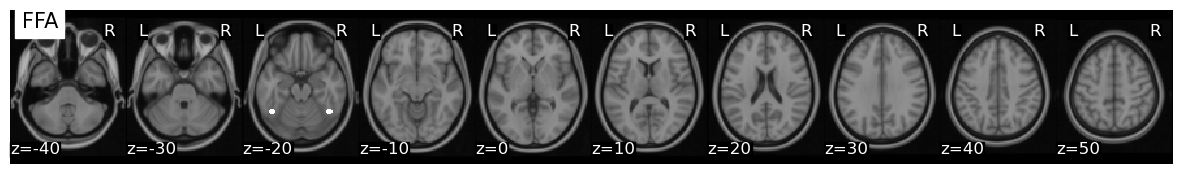

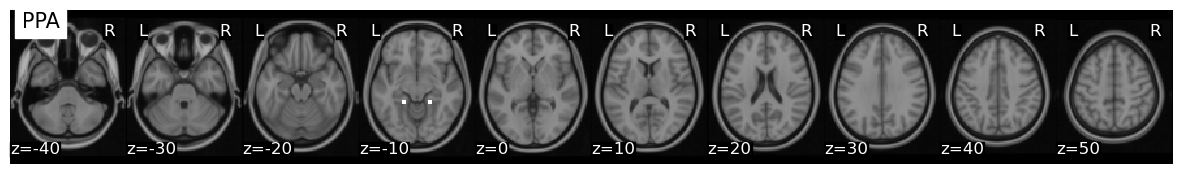

In [308]:
ffa = Brain_Data(create_sphere([44, -55, -22])) + Brain_Data(create_sphere([-44, -55, -22]))
ffa.plot(title='FFA')

ppa = Brain_Data(create_sphere([-20, -40, -6])) + Brain_Data(create_sphere([20, -40, -6]))
ppa.plot(title='PPA')

Next, let's simulate an actual brain response for each region. We will create an impulse response for one TR for each trial of viewing a face or a house and then convolve these responses with a canonical double gamma hemodynamic response function (HRF).

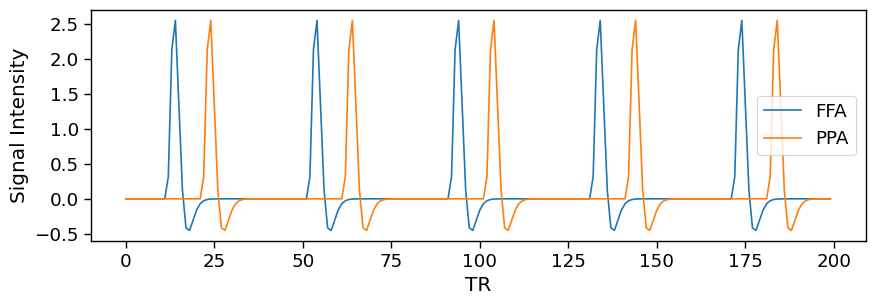

In [313]:
ffa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ffa_signal.iloc[np.arange(10, n_tr, int(n_tr/n_trial))] = signal_intensity
ffa_signal = ffa_signal.convolve()    

ppa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ppa_signal.iloc[np.arange(20, n_tr, int(n_tr/n_trial))] = signal_intensity
ppa_signal = ppa_signal.convolve()    

with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(figsize=(10,3))
    ffa_signal.plot(ax=a)
    ppa_signal.plot(ax=a)
    a.legend(['FFA', 'PPA'])
    a.set_xlabel('TR')
    a.set_ylabel('Signal Intensity')

Finally, we need to place these brain responses to faces and houses in the FFA and PPA masks. We will add random Gaussian noise to each TR independently for each voxel.

Now let's plot the average voxel activity over time from our simulated participant data.

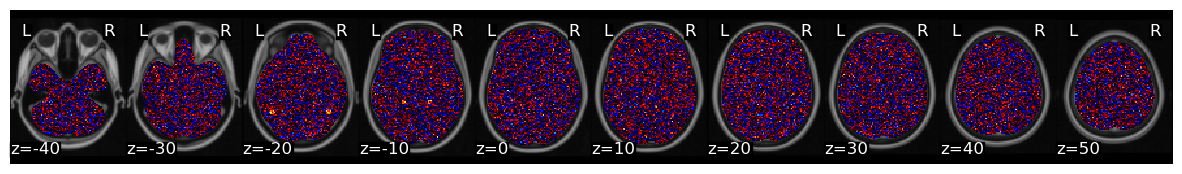

In [314]:
# Initialize an empty brain for 200 TRs
simulated_data = Brain_Data(get_anatomical())
simulated_data.data = np.zeros([n_tr, simulated_data.shape()[0]])

# Add brain signal to each ROI
simulated_data.data[:, ffa.data==1] = pd.concat([ffa_signal.T]*ffa.data.sum().astype(int)).T
simulated_data.data[:, ppa.data==1] = pd.concat([ppa_signal.T]*ppa.data.sum().astype(int)).T

# Add Noise to each voxel and TR
simulated_data.data += np.random.randn(simulated_data.data.shape[0], simulated_data.data.shape[1]) * sigma

# Plot average voxel activity over time
simulated_data.mean().plot()


As you can see, there is a small amount of signal in both the PPA and FFA ROIs that stands out among the noise. There are of course many ways to improve this simulation by adding additional properties that we know about the brain. For example, we could add real physiological artifacts such as respiration or cardiac signals. We could also add autocorrelation within a voxel, or scanner drifts and spikes. For now we will just be using this very simple example.

Now, let's try to use spatial ICA to identify two independent components from our simulated participant's data based on our hypothetical experiment.

/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


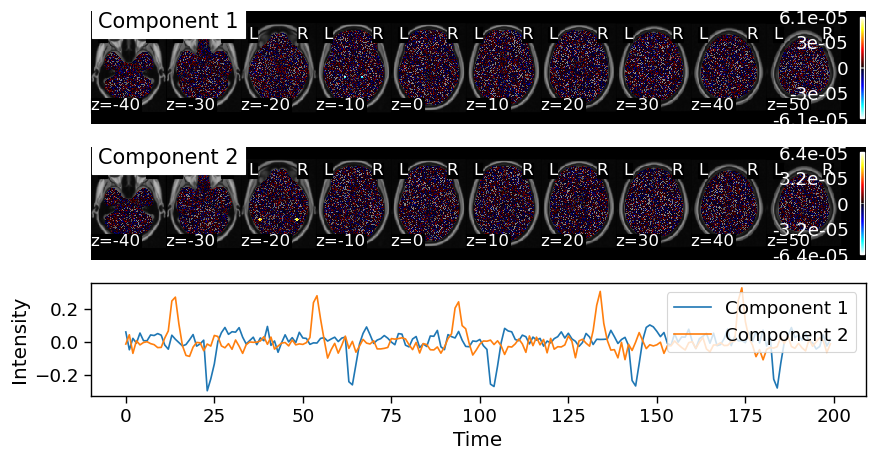

In [315]:
decomposed_voxels = simulated_data.decompose(algorithm='ica', axis='voxels', n_components=2)

with sns.plotting_context(context='paper', font_scale=1.5):
  
  f,a = plt.subplots(nrows=3, figsize=(10,5))
  decomposed_voxels['components'][0].plot(colorbar = True, title='Component 1', axes=a[0])
  decomposed_voxels['components'][1].plot(colorbar = True, title='Component 2', axes=a[1])

  a[2].plot(decomposed_voxels['weights'])
  a[2].set_ylabel('Intensity')
  a[2].set_xlabel('Time')
  a[2].legend(['Component 1', 'Component 2'])


ICA was able to successfully identify signals in the PPA and FFA corresponding to timecourses associated with viewing each trial. The spatial maps indicate the weights to project each voxel's activity into the latent timeseries. The time series for each spatial map can be seen in the third panel.  Notice how ICA identified the correct voxels and timepoints, but it may have gotten the signs incorrect. In this example Component 1 is negative, but Component 2 is positive. ICA is only able to resolve independent signals, but these signals are invariant to the sign.

We could also transpose our data and run a temporal ICA by switching the `axis` flag to `images` from `voxels`. 

/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


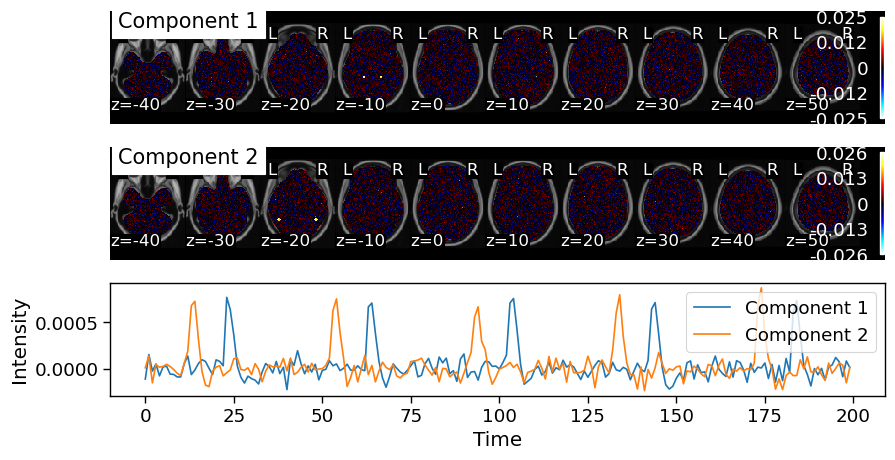

In [317]:
decomposed_voxels = simulated_data.decompose(algorithm='ica', axis='images', n_components=2)

with sns.plotting_context(context='paper', font_scale=1.5):
  f,a = plt.subplots(nrows=3, figsize=(10,5))
  decomposed_voxels['components'][0].plot(colorbar = True, title='Component 1', axes=a[0])
  decomposed_voxels['components'][1].plot(colorbar = True, title='Component 2', axes=a[1])

  a[2].plot(decomposed_voxels['weights'])
  a[2].set_ylabel('Intensity')
  a[2].set_xlabel('Time')
  a[2].legend(['Component 1', 'Component 2'])

When the signals are independent and have a relatively high signal to noise ratio (SNR), both spatial and temporal ICA are able to successfully recover our simulated signals.

*What about other types of scenarios when the temporal signals are more intertwined?*

## Overlapping temporal signals simulation

Let's simulate a slightly different scenario to explore this more. Here we will now give different signal intensities to the face and house signals. Let's also assume that there might be a weaker response in the PPA when viewing faces, but this signal might be slightly delayed by one TR as perceiving a house could be slower than perceiving a face.


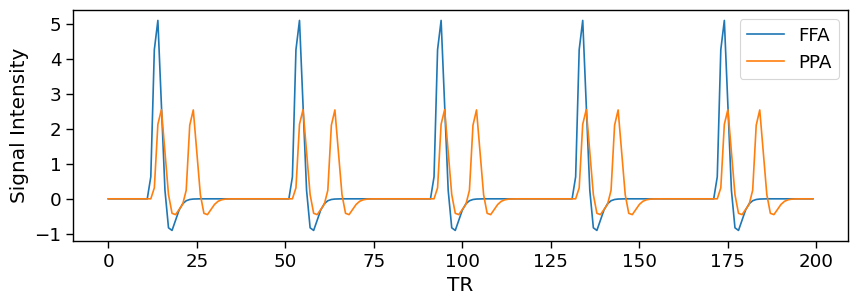

In [336]:
n_tr = 200
n_trial = 5
tr = 2
sigma = 0.75
signal_intensity_1 = 10
signal_intensity_2 = 5

simulated_data = Brain_Data(get_anatomical())
simulated_data.data = np.zeros([n_tr, simulated_data.shape()[0]])

ffa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ffa_signal.iloc[np.arange(10, n_tr, int(n_tr/n_trial))] = signal_intensity_1
ffa_signal = ffa_signal.convolve()    

ppa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ppa_signal.iloc[np.arange(11, n_tr, int(n_tr/n_trial))] = signal_intensity_2
ppa_signal.iloc[np.arange(20, n_tr, int(n_tr/n_trial))] = signal_intensity_2
ppa_signal = ppa_signal.convolve()    

simulated_data.data[:, ffa.data==1] = pd.concat([ffa_signal.T]*ffa.data.sum().astype(int)).T
simulated_data.data[:, ppa.data==1] = pd.concat([ppa_signal.T]*ppa.data.sum().astype(int)).T

# Add Noise
simulated_data.data += np.random.randn(simulated_data.data.shape[0],simulated_data.data.shape[1]) * sigma


with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(figsize=(10,3))
    ffa_signal.plot(ax=a)
    ppa_signal.plot(ax=a)
    a.legend(['FFA', 'PPA'])
    a.set_xlabel('TR')
    a.set_ylabel('Signal Intensity')



Notice how our simulated brain responses reflect the goals of the simulation?

These signals are now no longer independent and have a correlation of r=0.49.

Text(2, 0, 'r = 0.49')

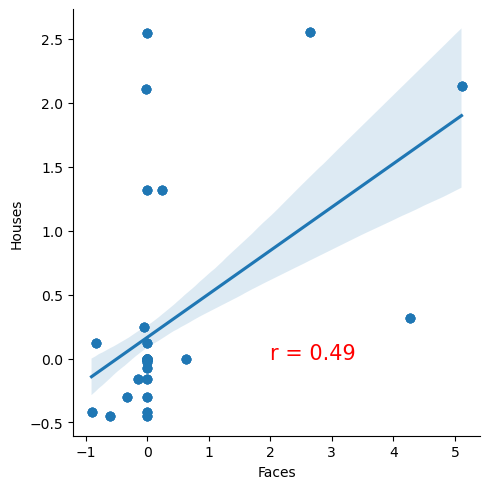

In [356]:

combined = pd.concat([ffa_signal, ppa_signal], axis=1)
combined.columns = ['Faces', 'Houses']
sns.lmplot(data=combined, x='Faces', y='Houses')
plt.text(2,0, f'r = {pearsonr(ffa_signal.iloc[:,0], ppa_signal.iloc[:,0])[0]:.02}', {'fontsize':15, 'color':'red'})


Now, let's see how well spatial and temporal ICA are able to to recover these signals

/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


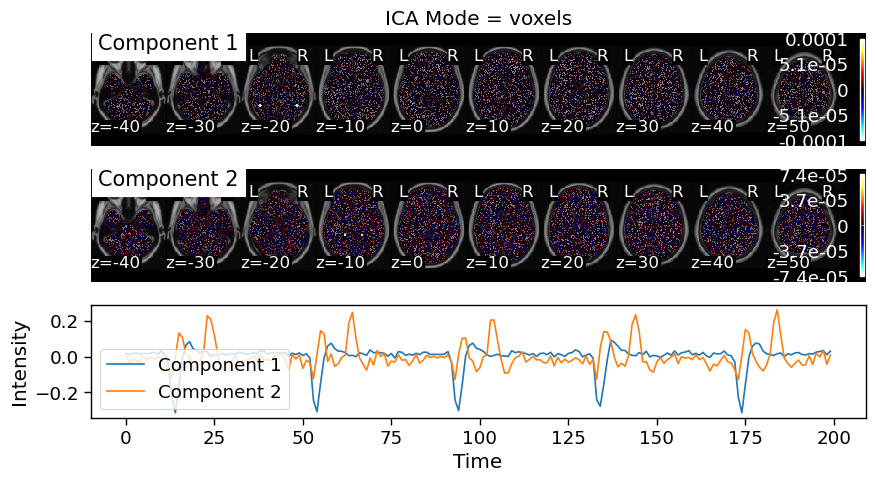

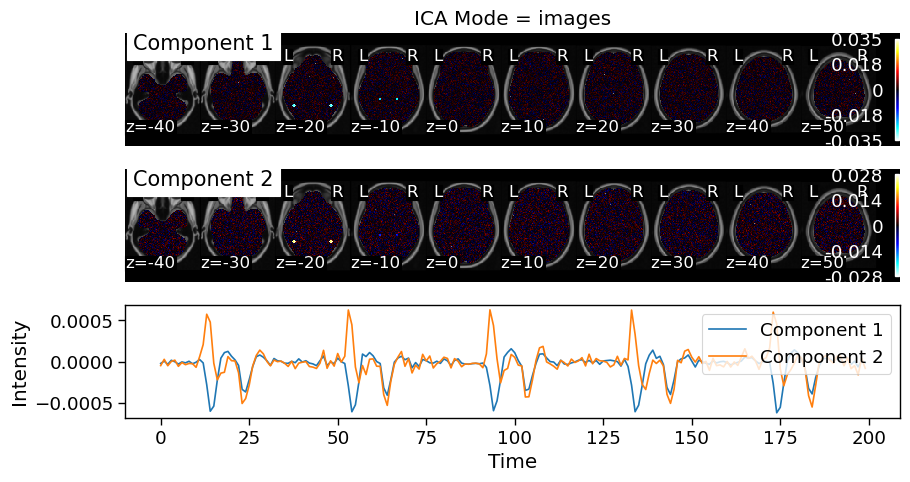

In [321]:
for ica_mode in ['voxels', 'images']:
  
  decomposed_voxels = simulated_data.decompose(algorithm='ica', axis=ica_mode, n_components=2)

  with sns.plotting_context(context='paper', font_scale=1.5):
    
    f,a = plt.subplots(nrows=3, figsize=(10,5))
    decomposed_voxels['components'][0].plot(colorbar = True, title='Component 1', axes=a[0])
    decomposed_voxels['components'][1].plot(colorbar = True, title='Component 2', axes=a[1])

    a[2].plot(decomposed_voxels['weights'])
    a[2].set_ylabel('Intensity')
    a[2].set_xlabel('Time')
    a[2].legend(['Component 1', 'Component 2'])
    a[0].set_title(f'ICA Mode = {ica_mode}')

Both spatial and temporal ICA are able to successfully recover the signals. However, there are some slight nuances to how well they perform in this specific simulation. Notice how the spatial ICA is able to successfully identify the different spatial signals and the corresponding signals. Temporal ICA does not work quite as well in this example. Component 1 includes activity in both the FFA and PPA regions. Component 2 only has weights in the FFA, but goes up in the Face condition and down in the House condition.  

## Overlapping spatial signals simulation

*What about other situations, where temporal signals might be more intermixed **within** ROIs?* 

In our final simulation we will include populations of voxels in the FFA that purely respond to faces, and a population of PPA voxels that selectively respond to houses. This is identicial to the first simulation. However, we are now also including a population of voxels in the FFA that weakly respond to both faces **and** houses. 

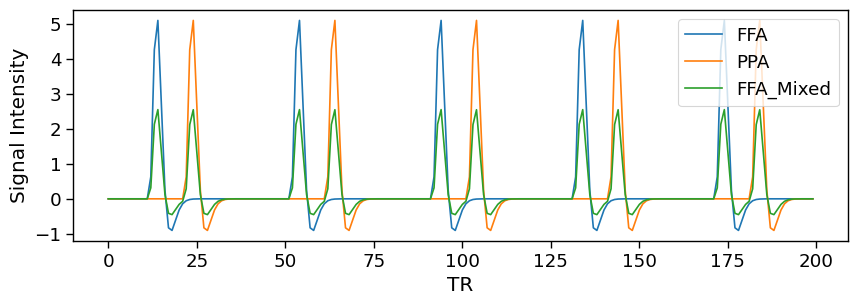

In [382]:
n_tr = 200
n_trial = 5
tr = 2
sigma = 0.75
signal_intensity_1 = 10
signal_intensity_2 = 5

simulated_data = Brain_Data(get_anatomical())
simulated_data.data = np.zeros([n_tr, simulated_data.shape()[0]])

ffa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ffa_signal.iloc[np.arange(10, n_tr, int(n_tr/n_trial))] = signal_intensity_1
ffa_signal = ffa_signal.convolve()    

ppa_signal = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ppa_signal.iloc[np.arange(20, n_tr, int(n_tr/n_trial))] = signal_intensity_1
ppa_signal = ppa_signal.convolve()

ppa_signal_2 = Design_Matrix(np.zeros(n_tr), sampling_freq=1/tr)
ppa_signal_2.iloc[np.arange(10, n_tr, int(n_tr/n_trial))] = signal_intensity_2
ppa_signal_2.iloc[np.arange(20, n_tr, int(n_tr/n_trial))] = signal_intensity_2
ppa_signal_2 = ppa_signal_2.convolve()    


simulated_data.data[:, ffa.data==1] = pd.concat([pd.concat([ffa_signal.T]*int(ffa.data.sum()/4)).T,
                                                 pd.concat([ppa_signal_2.T]*int(ffa.data.sum()/4)).T,
                                                 pd.concat([ffa_signal.T]*int(ffa.data.sum()/4)).T,
                                                 pd.concat([ppa_signal_2.T]*int(ffa.data.sum()/4)).T], axis=1)
simulated_data.data[:, ppa.data==1] = pd.concat([ppa_signal.T]*ppa.data.sum().astype(int)).T

# Add Noise
simulated_data.data += np.random.randn(simulated_data.data.shape[0],simulated_data.data.shape[1]) * sigma

with sns.plotting_context(context='paper', font_scale=1.5):
    f,a = plt.subplots(figsize=(10,3))
    ffa_signal.plot(ax=a)
    ppa_signal.plot(ax=a)
    ppa_signal_2.plot(ax=a)
    a.legend(['FFA','PPA','FFA_Mixed'])
    a.set_xlabel('TR')
    a.set_ylabel('Signal Intensity')
    

/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(
/Users/lukechang/opt/anaconda3/lib/python3.9/site-packages/sklearn/decomposition/_fastica.py:494: FutureWarning: Starting in v1.3, whiten='unit-variance' will be used by default.
  warnings.warn(


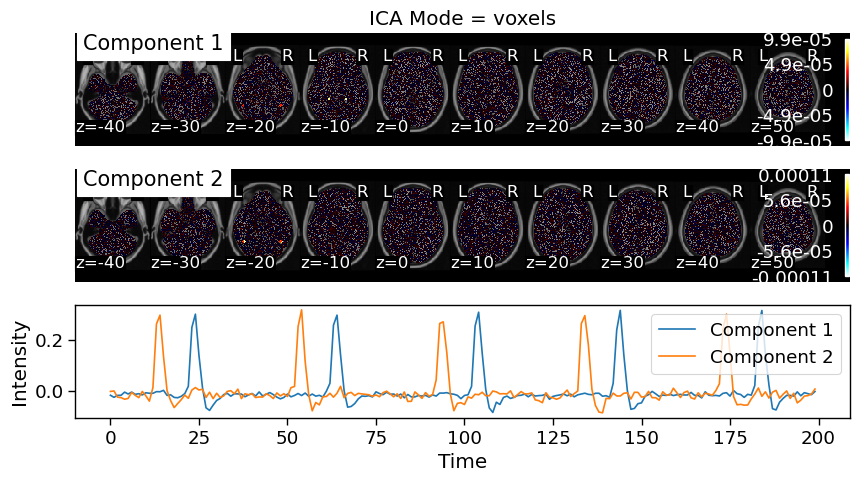

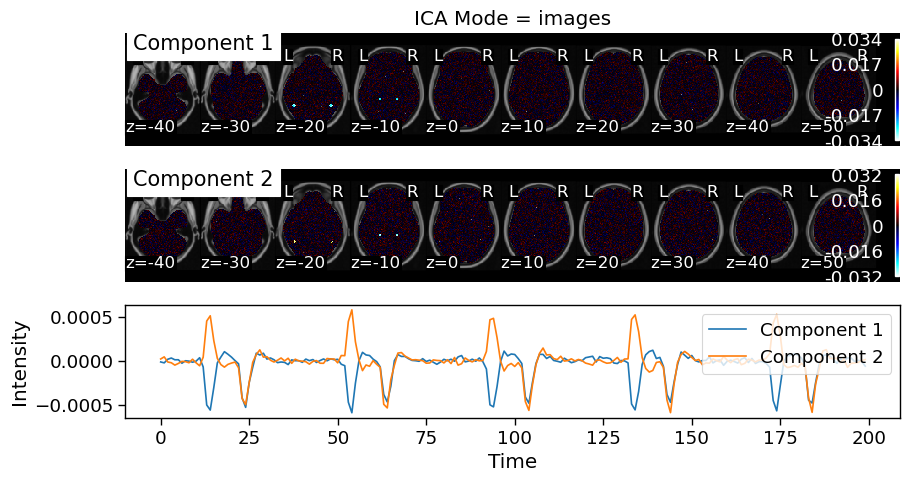

In [383]:
for ica_mode in ['voxels', 'images']:
  
  decomposed_voxels = simulated_data.decompose(algorithm='ica', axis=ica_mode, n_components=2)

  with sns.plotting_context(context='paper', font_scale=1.5):
    
    f,a = plt.subplots(nrows=3, figsize=(10,5))
    decomposed_voxels['components'][0].plot(colorbar = True, title='Component 1', axes=a[0])
    decomposed_voxels['components'][1].plot(colorbar = True, title='Component 2', axes=a[1])

    a[2].plot(decomposed_voxels['weights'])
    a[2].set_ylabel('Intensity')
    a[2].set_xlabel('Time')
    a[2].legend(['Component 1', 'Component 2'])
    a[0].set_title(f'ICA Mode = {ica_mode}')

In this simulation, we see a different pattern of results. Spatial ICA seems to to do the best job in this simulation. Component 2 appears to include voxels that only respond to faces and it correctly identifies that half of theese voxels have a stronger response to faces compared to the other half. Component 1 identifies voxels that responds to houses and includes all of the voxels in the PPA and half of the voxels in the FFA. 

Temporal ICA finds a different pattern of results. Similar to spatial ICA, Component 1 includes voxels in the PPA and FFA. However, the time course of this component does not differentiate between faces and houses, instead it goes up for both faces and houses. Component 2 goes up for faces and down for houses, even though this was not a feature of the simulation. It introduces a spatial artifact such that it includes voxels with negative weights in the PPA.

There are of course an infinite number of possible ways real brain activity could manifest, but these types of simulations allow us to better understand how different analytic approaches might work in different contexts. 

*Can you think of another simulation that might be able to show how spatial and temporal ICA might perform differently?*


## Other considerations

Typical ICA approaches don't account for inter-subject variability, and as a result, the underlying signals and networks may be mis-characterized and thus generate group-differences that aren't really there (false positive) or fail to detect differences amongst groups that are actually there (false negative).  We recommend using either GIFT or Melodic or nilearn for performing group ICA.
